# bRAG: Indexing and Advanced Retrieval

![indexing_overview](https://github.com/tivon-x/bRAG-langchain/blob/main/notebooks/image/indexing_overview.png?raw=1)

## 前言: Chunking

我们没有明确涵盖文档分块 chunking /拆分 spliting。

有关文档分块的精彩回顾，请观看Greg Kamradt的视频：

https://www.youtube.com/watch?v=8OJC21T2SL4

In [1]:
! pip3 install --quiet python-dotenv langchain_community tiktoken langchain-openai langchainhub chromadb langchain youtube-transcript-api pytube yt_dlp

In [2]:
! pip install --upgrade --quiet  dashscope

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.9 MB/s eta 0:00:00


In [ ]:
! pip install langchain-chroma --quiet

## Environment

`(1) Packages`

In [3]:
# 非colab环境
import os
from dotenv import load_dotenv

# 从 .env 文件加载所有环境变量
load_dotenv()

# LangSmith
langsmith_tracing = os.getenv('LANGSMITH_TRACING')
langsmith_endpoint = os.getenv('LANGSMITH_ENDPOINT')
langsmith_api_key = os.getenv('LANGSMITH_API_KEY')

## LLM
dashscope_api_key = os.getenv('DASHSCOPE_API_KEY')


In [1]:
# Colab环境
import os
from google.colab import userdata

langsmith_tracing = userdata.get('LANGSMITH_TRACING')
langsmith_endpoint = userdata.get('LANGSMITH_ENDPOINT')
langsmith_api_key = userdata.get('LANGSMITH_API_KEY')

dashscope_api_key = userdata.get("DASHSCOPE_API_KEY")

`(2) LangSmith`

https://docs.smith.langchain.com/

In [2]:
os.environ['LANGSMITH_TRACING'] = langsmith_tracing
os.environ['LANGSMITH_ENDPOINT'] = langsmith_endpoint
os.environ['LANGSMITH_API_KEY'] = langsmith_api_key

`(3) API Keys`

In [3]:
# langchain的webbaseloader需要
os.environ["USER_AGENT"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"

In [4]:
# 使用阿里云百炼平台
os.environ['DASHSCOPE_API_KEY'] = dashscope_api_key
dashscope_model = "qwen-plus-latest"

## Multi-representation Indexing

Flow:

![multi_representation](https://github.com/tivon-x/bRAG-langchain/blob/main/notebooks/image/multi-representation.png?raw=1)


通常，为每个文档存储多个 [向量](https://python.langchain.ac.cn/docs/concepts/vectorstores/) 会很有用。在多种用例中，这都很有益。例如，我们可以 [嵌入](https://python.langchain.ac.cn/docs/concepts/embedding_models/) 文档的多个块，并将这些嵌入与父文档关联，从而允许对块的 [检索器](https://python.langchain.ac.cn/docs/concepts/retrievers/) 命中返回更大的文档。

LangChain 实现了基础 [MultiVectorRetriever](https://python.langchain.ac.cn/api_reference/langchain/retrievers/langchain.retrievers.multi_vector.MultiVectorRetriever.html)，从而简化了此过程。大部分复杂性在于如何为每个文档创建多个向量。本笔记本涵盖了一些创建这些向量并使用 `MultiVectorRetriever` 的常用方法。

为每个文档创建多个向量的方法包括

- 更小的块：将文档拆分为更小的块，并嵌入这些块（这是 [ParentDocumentRetriever](https://python.langchain.ac.cn/api_reference/langchain/retrievers/langchain.retrievers.parent_document_retriever.ParentDocumentRetriever.html)）。
- 摘要：为每个文档创建摘要，并将摘要与文档一起（或代替文档）嵌入。
- 假设性问题：创建每个文档都适合回答的假设性问题，并将这些问题与文档一起（或代替文档）嵌入。

Docs:

https://blog.langchain.dev/semi-structured-multi-modal-rag/

https://python.langchain.com/docs/how_to/multi_vector/

Paper:

https://arxiv.org/abs/2312.06648

In [5]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

### 更小的块
通常，检索较大的信息块可能很有用，但嵌入较小的块。这允许嵌入尽可能地捕获语义含义，但允许尽可能多的上下文向下游传递。请注意，这就是 [ParentDocumentRetriever](https://python.langchain.ac.cn/api_reference/langchain/retrievers/langchain.retrievers.parent_document_retriever.ParentDocumentRetriever.html) 的作用。这里我们展示了幕后发生的事情。

In [6]:
from langchain_community.embeddings import DashScopeEmbeddings
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

embeddings = DashScopeEmbeddings(model="text-embedding-v4")

text_splitter = RecursiveCharacterTextSplitter(chunk_size=10000)
docs = text_splitter.split_documents(docs)

# 存储更小的子块
vectorstore = Chroma(
    collection_name="full_documents", embedding_function=embeddings
)


在这里，我们将区分向量存储（索引（子）文档的嵌入，vectorstore）和文档存储（存储“父”文档并将它们与标识符关联吗，docstore）。

In [7]:
import uuid
from langchain.storage import InMemoryByteStore

from langchain.retrievers.multi_vector import MultiVectorRetriever

# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)

doc_ids = [str(uuid.uuid4()) for _ in docs]

接下来，我们通过拆分原始文档`docs`来生成“子”文档。请注意，我们将文档标识符存储在相应 Document 对象的 metadata 中。

In [8]:
# 创建更小的块
child_text_splitter = RecursiveCharacterTextSplitter(chunk_size=400)

sub_docs = []
for i, doc in enumerate(docs):
    _id = doc_ids[i]
    _sub_docs = child_text_splitter.split_documents([doc])
    for _doc in _sub_docs:
      # 添加元数据指向原始文档
        _doc.metadata[id_key] = _id
    sub_docs.extend(_sub_docs)

最后，我们在向量存储和文档存储中索引文档

In [9]:
def batch_read(lst, batch_size=10):
    for i in range(0, len(lst), batch_size):
        yield lst[i:i + batch_size]

# qwen的嵌入模型只支持batch_size=10
for batch in batch_read(sub_docs):
  vectorstore.add_documents(batch)

retriever.docstore.mset(list(zip(doc_ids, docs)))

单独的向量存储将检索小块

In [10]:
retriever.vectorstore.similarity_search("Memory in agents")[0]

Document(id='1f9f89b7-260f-4195-830d-5ff5190092de', metadata={'title': "LLM Powered Autonomous Agents | Lil'Log", 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'language': 'en', 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them f

而检索器将返回更大的父文档

In [11]:
len(retriever.invoke("justice breyer")[0].page_content)

9850

检索器在向量数据库上执行的默认搜索类型是相似性搜索。LangChain 向量存储也支持通过 [最大边际相关性](https://python.langchain.ac.cn/api_reference/core/vectorstores/langchain_core.vectorstores.base.VectorStore.html#langchain_core.vectorstores.base.VectorStore.max_marginal_relevance_search) 进行搜索。这可以通过检索器的 `search_type` 参数来控制

In [12]:
from langchain.retrievers.multi_vector import SearchType

retriever.search_type = SearchType.mmr

len(retriever.invoke("justice breyer")[0].page_content)

9850

### 摘要

摘要可能能够更准确地提炼出一个块的内容，从而实现更好的检索。这里我们展示如何创建摘要，然后嵌入这些摘要。

我们构建一个简单的 [链](https://python.langchain.ac.cn/docs/how_to/sequence/)，它将接收一个输入 [Document](https://python.langchain.ac.cn/api_reference/core/documents/langchain_core.documents.base.Document.html) 对象，并使用 LLM 生成摘要。

请注意，我们可以跨文档 [批量处理](https://python.langchain.ac.cn/api_reference/core/runnables/langchain_core.runnables.base.Runnable.html#langchain_core.runnables.base.Runnable) 链——`batch`



In [13]:
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.chat_models.tongyi import ChatTongyi

llm = ChatTongyi(model=dashscope_model, temperature=0.1)

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | llm
    | StrOutputParser()
)

# 在输入列表上调用链，设置最大并发数为5
summaries = chain.batch(docs, {"max_concurrency": 5})

我们可以像之前一样初始化 `MultiVectorRetriever`，在向量存储中索引摘要，并在文档存储中保留原始文档

In [15]:
# 基于内存的向量数据库，存储子chunks——摘要
vectorstore = Chroma(collection_name="summaries",
                     embedding_function=embeddings)

# 存储父文档
store = InMemoryByteStore()
id_key = "doc_id"

# 多向量检索器
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

# 增加元数据
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

# Add
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

查询向量存储将返回摘要

In [16]:
query = "Memory in agents"
sub_docs = vectorstore.similarity_search(query,k=1)
sub_docs[0]

Document(id='fcec149d-907f-408c-ab06-4ee480e8e14b', metadata={'doc_id': 'e29e9d04-7695-4cb1-bf0d-e2013af61334'}, page_content='### Summary of *LLM Powered Autonomous Agents* by Lilian Weng\n\nThis article explores the design and implementation of autonomous agents powered by **Large Language Models (LLMs)**. These agents are capable of performing complex tasks through a combination of **planning**, **memory**, and **tool use**.\n\n---\n\n### **Agent System Overview**\n\nAn LLM-powered autonomous agent system uses the LLM as its central controller, augmented with three key components:\n\n1. **Planning**: Enables task decomposition and self-reflection for iterative improvement.\n2. **Memory**: Includes short-term memory (via in-context learning) and long-term memory (using external vector stores).\n3. **Tool Use**: Allows the agent to interact with external APIs or tools for real-time data, code execution, and more.\n\n---\n\n### **Component One: Planning**\n\n- **Task Decomposition**:\n

而检索器将返回更大的源文档

In [18]:
retrieved_docs = retriever.invoke("Memory in agents")

len(retrieved_docs[0].page_content)

8953

In [19]:
retrieved_docs = retriever.get_relevant_documents(query,n_results=1)
retrieved_docs[0].page_content[0:500]

<ipython-input-19-3791815623>:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(query,n_results=1)


"LLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three: Tool "

### 假设性查询
LLM 也可用于生成特定文档可能被问到的一系列假设性问题，这些问题可能与 [RAG](https://python.langchain.ac.cn/docs/tutorials/rag/) 应用程序中的相关查询具有密切的语义相似性。然后，可以将这些问题嵌入并与文档关联，以改进检索。

下面，我们使用 [with_structured_output](https://python.langchain.ac.cn/docs/how_to/structured_output/) 方法将 LLM 输出结构化为字符串列表。

In [46]:
from typing import List

from pydantic import BaseModel, Field


class HypotheticalQuestions(BaseModel):
    """Generate hypothetical questions."""

    questions: List[str] = Field(..., description="List of questions")


chain = (
    {"doc": lambda x: x.page_content}
    # Only asking for 3 hypothetical questions, but this could be adjusted
    | ChatPromptTemplate.from_template(
        """Imagine you have access to the information in the document below.
        List exactly 3 hypothetical questions that could be answered using only the details presented in this document.


        <document>
        {doc}
        </document>
        """
    )
    | ChatTongyi(model=dashscope_model, temperature=0).with_structured_output(HypotheticalQuestions)
    | (lambda x: x.questions)
)

我们可以批量处理所有文档上的链，并像之前一样组装我们的向量存储和文档存储

In [50]:
hypothetical_questions = chain.batch(docs, {"max_concurrency": 1})

In [51]:
vectorstore = Chroma(
    collection_name="hypo-questions", embedding_function=embeddings
)

store = InMemoryByteStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]


# 将假设性查询转换为文档对象
question_docs = []
for i, question_list in enumerate(hypothetical_questions):
    question_docs.extend(
        [Document(page_content=s, metadata={id_key: doc_ids[i]}) for s in question_list]
    )

for batch in batch_read(question_docs):
  retriever.vectorstore.add_documents(batch)

retriever.docstore.mset(list(zip(doc_ids, docs)))

请注意，查询底层向量存储将检索与输入查询语义相似的假设性问题



In [53]:
sub_docs = retriever.vectorstore.similarity_search("memory in agent")

sub_docs

[Document(id='8b16b068-e491-4562-a5e3-b14fe179bbd8', metadata={'doc_id': 'c9ea8765-4d31-4632-92af-52f34f6f7f89'}, page_content='How does Reflexion framework use dynamic memory and self-reflection to enhance agent reasoning skills?'),
 Document(id='a4b7821a-2651-488e-b342-d8a86b8c63a9', metadata={'doc_id': 'a643ffee-87d9-479f-babe-cd78e9b93c19'}, page_content='What are the key components of the Generative Agents architecture that enable believable human-like behavior in a sandbox environment?'),
 Document(id='cca5074e-7659-4e04-b533-ed12a104829a', metadata={'doc_id': 'edc7e568-6c5f-4035-8a54-950ce70c1fc4'}, page_content='What are the common limitations of building LLM-centered agents as discussed in the document?'),
 Document(id='646e82b9-bc25-472c-8d77-d2e0d45908e0', metadata={'doc_id': 'edc7e568-6c5f-4035-8a54-950ce70c1fc4'}, page_content='How can vector stores and retrieval mechanisms help address the issue of finite context length in LLMs?')]

调用检索器将返回相应的文档

In [54]:
retrieved_docs = retriever.invoke("justice breyer")
len(retrieved_docs[0].page_content)

9850

## RAPTOR + Long Context LLM
对于长上下文窗口（long context）的LLM来说，直接将文档输入给LLM来进行检索回答比RAG更方便、高效。

但是，仍然存在上下文窗口长度限制的问题，如果是非本地模型，还有费用和延迟的问题，RAG仍然有存在的必要。

对于基于 Long Context LLM 的 RAG，是否有一种方法能够简化文档分块并且充分利用长上下文窗口？

- 方法一：每篇文档嵌入 + KNN搜索（k需要调参，k个文档不一定包含所有信息）
- 方法二：RAPTOR——每篇文档嵌入 + 建立文档树

Flow:

![raptor](https://github.com/tivon-x/bRAG-langchain/blob/main/notebooks/image/raptor.png?raw=1)

> leafs可以是文档的分块，或原始的文档

Deep dive video:

https://www.youtube.com/watch?v=jbGchdTL7d0

Paper:

https://arxiv.org/pdf/2401.18059.pdf

Full code:

https://github.com/langchain-ai/langchain/blob/master/cookbook/RAPTOR.ipynb

### 文档

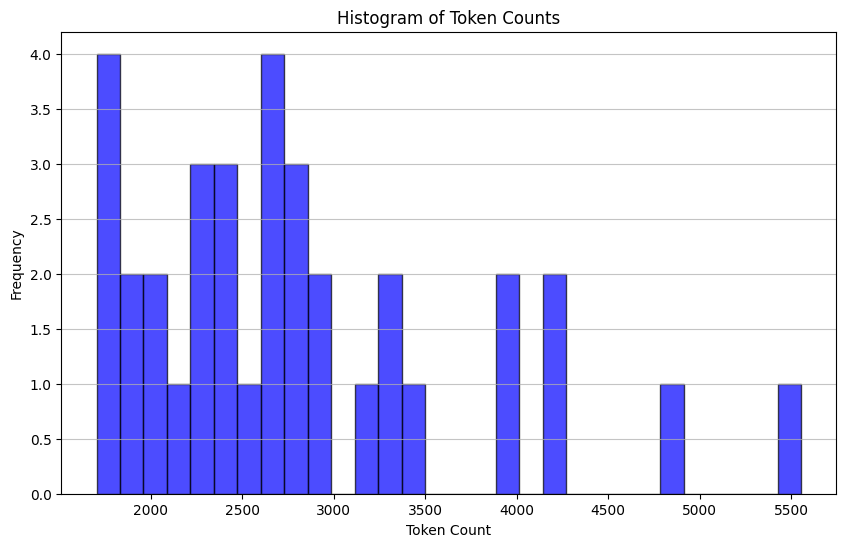

In [69]:
import matplotlib.pyplot as plt
import tiktoken
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader


def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


# concepts
url = "https://python.langchain.com/docs/concepts/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# retrievers教程
url = "https://python.langchain.com/docs/tutorials/retrievers/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()

# Self Query文档
url = "https://python.langchain.com/docs/integrations/retrievers/self_query/chroma_self_query/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()

# 文档文本
docs.extend([*docs_pydantic, *docs_sq])
docs_texts = [d.page_content for d in docs]

# 计算每个文档的token数量
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# token直方图
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

plt.show()

In [70]:
# Doc texts concat
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

Num tokens in all context: 98462


In [71]:
# Doc texts split
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(concatenated_content)

In [74]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224  # Fixed seed for reproducibility

### --- Code from citations referenced above (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embeddings` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = []

    for batch in batch_read(texts):
      text_embeddings.extend(embeddings.embed_documents(batch))

    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is a sub-set of LangChain Expression Language doc.

    LangChain Expression Language provides a way to compose chain in LangChain.

    Give a detailed summary of the documentation provided.

    Documentation:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | llm | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

In [75]:
# Build tree
leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


--Generated 7 clusters--
--Generated 1 clusters--


In [80]:
# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma(embedding_function=embeddings)

for batch in batch_read(all_texts):
  vectorstore.add_texts(batch)
retriever = vectorstore.as_retriever()

In [81]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt = hub.pull("rlm/rag-prompt")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
rag_chain.invoke("How to define a RAG chain? Give me a specific code example.")

'A RAG (Retrieval-Augmented Generation) chain combines a retriever and a language model to answer questions using external knowledge.  \nIt retrieves relevant documents from a knowledge base and feeds them to the model as context.  \nHere\'s a code example using LangChain:\n\n```python\nfrom langchain.chains.retrieval import create_retrieval_chain\nfrom langchain.chains.combine_documents import create_stuff_documents_chain\nfrom langchain_core.messages import HumanMessage\n\n# Define retriever and LLM\nretriever = ...  # Your vectorstore-based retriever\nllm = ...        # Your language model (e.g., ChatOpenAI)\n\n# Create document chain\nquestion_answer_chain = create_stuff_documents_chain(llm, prompt)\n\n# Create retrieval chain\nrag_chain = create_retrieval_chain(retriever, question_answer_chain)\n\n# Invoke\nresponse = rag_chain.invoke({"input": "What is LCEL?"})\nprint(response["answer"])\n```'

## ColBERT

RAGatouille使ColBERT的使用变得简单。

[ColBERT](https://github.com/stanford-futuredata/ColBERT) 是一种快速而准确的检索模型，可以在数十毫秒内对大型文本集合进行可扩展的基于 BERT 的搜索。

请参阅 [ColBERTv2](https://arxiv.org/abs/2112.01488) 论文。

ColBERT为段落中的每个 token 生成一个受上下文影响的向量。

ColBERT同样为查询中的每个 token 生成向量。

然后，每个文档的得分是每个查询嵌入与任何文档嵌入的最大相似度之和：

相关文档：
- [How ColBERT Helps Developers Overcome the Limits of RAG](https://hackernoon.com/how-colbert-helps-developers-overcome-the-limits-of-rag)
- [langchain ragatouille](https://python.langchain.com/docs/integrations/retrievers/ragatouille)
- [colbert-ragatouille](https://til.simonwillison.net/llms/colbert-ragatouille).

我们可以将其用作 langchain 的检索器。它将显示特定于此集成的功能。浏览完后，探索相关用例页面以了解如何将此向量存储用作更大链的一部分可能很有用。

In [55]:
!pip install -U ragatouille --quiet

In [57]:
from ragatouille import RAGPretrainedModel
RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

<ipython-input-57-276443619>:1: UserWarning: 
********************************************************************************
RAGatouille WARNING: Future Release Notice
--------------------------------------------
RAGatouille version 0.0.10 will be migrating to a PyLate backend 
instead of the current Stanford ColBERT backend.
PyLate is a fully mature, feature-equivalent backend, that greatly facilitates compatibility.
However, please pin version <0.0.10 if you require the Stanford ColBERT backend.
********************************************************************************
  from ragatouille import RAGPretrainedModel
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[Jun 13, 07:38:11] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/usr/local/lib/python3.11/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [58]:
import requests

def get_wikipedia_page(title: str):
    """
    Retrieve the full text content of a Wikipedia page.

    :param title: str - Title of the Wikipedia page.
    :return: str - Full text content of the page as raw string.
    """
    # Wikipedia API endpoint
    URL = "https://en.wikipedia.org/w/api.php"

    # Parameters for the API request
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,
    }

    # Custom User-Agent header to comply with Wikipedia's best practices
    headers = {"User-Agent": "RAGatouille_tutorial/0.0.1 (ben@clavie.eu)"}

    response = requests.get(URL, params=params, headers=headers)
    data = response.json()

    # Extracting page content
    page = next(iter(data["query"]["pages"].values()))
    return page["extract"] if "extract" in page else None

full_document = get_wikipedia_page("Hayao_Miyazaki")

In [59]:
RAG.index(
    collection=[full_document],
    index_name="Miyazaki-123",
    max_document_length=180,
    split_documents=True,
)

---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Jun 13, 08:05:20] #> Creating directory .ragatouille/colbert/indexes/Miyazaki-123 


[Jun 13, 08:05:23] [0] 		 #> Encoding 123 passages..


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 4/4 [01:11<00:00, 17.92s/it]

[Jun 13, 08:06:35] [0] 		 avg_doclen_est = 132.46340942382812 	 len(local_sample) = 123
[Jun 13, 08:06:35] [0] 		 Creating 1,024 partitions.
[Jun 13, 08:06:35] [0] 		 *Estimated* 16,292 embeddings.
[Jun 13, 08:06:35] [0] 		 #> Saving the indexing plan to .ragatouille/colbert/indexes/Miyazaki-123/plan.json ..


used 20 iterations (7.3774s) to cluster 15479 items into 1024 clusters
[0.037, 0.042, 0.04, 0.036, 0.034, 0.037, 0.035, 0.038, 0.034, 0.036, 0.036, 0.037, 0.036, 0.039, 0.035, 0.038, 0.035, 0.034, 0.034, 0.038, 0.035, 0.034, 0.036, 0.036, 0.037, 0.033, 0.039, 0.035, 0.035, 0.035, 0.038, 0.038, 0.04, 0.037, 0.034, 0.033, 0.038, 0.035, 0.037, 0.04, 0.037, 0.041, 0.035, 0.037, 0.038, 0.034, 0.037, 0.038, 0.037, 0.034, 0.034, 0.035, 0.036, 0.036, 0.037, 0.037, 0.04, 0.037, 0.042, 0.032, 0.034, 0.038, 0.037, 0.036, 0.037, 0.037, 0.035, 0.038, 0.034, 0.035, 0.036, 0.033, 0.036, 0.036, 0.035, 0.035, 0.035, 0.04, 0.036, 0.037, 0.037, 0.04, 0.035, 0.041, 0.034, 0.036, 0.039, 0.038, 0.033, 0.042, 0.035, 0.038, 0.036, 0.042, 0.036, 0.037, 0.038, 0.037, 0.038, 0.037, 0.04, 0.039, 0.038, 0.034, 0.037, 0.036, 0.039, 0.034, 0.036, 0.033, 0.037, 0.035, 0.036, 0.034, 0.04, 0.037, 0.036, 0.038, 0.038, 0.041, 0.032, 0.035, 0.036, 0.039, 0.034, 0.039, 0.037, 0.038]


0it [00:00, ?it/s]

[Jun 13, 08:06:42] [0] 		 #> Encoding 123 passages..



100%|██████████| 4/4 [01:08<00:00, 17.23s/it]
1it [01:09, 69.29s/it]
100%|██████████| 1/1 [00:00<00:00, 704.21it/s]

[Jun 13, 08:07:52] #> Optimizing IVF to store map from centroids to list of pids..
[Jun 13, 08:07:52] #> Building the emb2pid mapping..
[Jun 13, 08:07:52] len(emb2pid) = 16293



100%|██████████| 1024/1024 [00:00<00:00, 45632.89it/s]

[Jun 13, 08:07:52] #> Saved optimized IVF to .ragatouille/colbert/indexes/Miyazaki-123/ivf.pid.pt
Done indexing!


'.ragatouille/colbert/indexes/Miyazaki-123'

In [60]:
results = RAG.search(query="What animation studio did Miyazaki found?", k=3)
results

Loading searcher for index Miyazaki-123 for the first time... This may take a few seconds
[Jun 13, 08:08:37] #> Loading codec...
[Jun 13, 08:08:37] #> Loading IVF...
[Jun 13, 08:08:37] Loading segmented_lookup_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jun 13, 08:09:11] #> Loading doclens...


100%|██████████| 1/1 [00:00<00:00, 4462.03it/s]

[Jun 13, 08:09:11] #> Loading codes and residuals...



100%|██████████| 1/1 [00:00<00:00, 461.83it/s]

[Jun 13, 08:09:11] Loading filter_pids_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


[Jun 13, 08:09:40] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What animation studio did Miyazaki found?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  7284,  2996,  2106,  2771,  3148, 18637,  2179,
         1029,   102,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])



/usr/local/lib/python3.11/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[{'content': '=== Studio Ghibli ===\n\n\n==== Early films (1985–1995) ====\nFollowing the success of Nausicaä of the Valley of the Wind, Miyazaki and Takahata founded the animation production company Studio Ghibli on June 15, 1985, as a subsidiary of Tokuma Shoten, with offices in Kichijōji designed by Miyazaki. The studio\'s name had been registered a year earlier; Miyazaki named it after the nickname of the Caproni Ca.309 aircraft, meaning "a hot wind that blows in the desert" in Italian.',
  'score': 25.729171752929688,
  'rank': 1,
  'document_id': '740da8e0-1b74-4b6d-8df5-e8193d4b5ec9',
  'passage_id': 42},
 {'content': 'Hayao Miyazaki (宮崎 駿 or 宮﨑 駿, Miyazaki Hayao, [mijaꜜzaki hajao]; born January 5, 1941) is a Japanese animator, filmmaker, and manga artist. He co-founded Studio Ghibli and serves as honorary chairman. Throughout his career, Miyazaki has attained international acclaim as a masterful storyteller and creator of Japanese animated feature films, and is widely regarded 

我们可以轻松转换为 LangChain 检索器！我们可以在创建时传入任何我们想要的 kwargs（例如 `k`）

In [61]:
retriever = RAG.as_langchain_retriever(k=3)
retriever.invoke("What animation studio did Miyazaki found?")

/usr/local/lib/python3.11/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[Document(metadata={}, page_content='=== Studio Ghibli ===\n\n\n==== Early films (1985–1995) ====\nFollowing the success of Nausicaä of the Valley of the Wind, Miyazaki and Takahata founded the animation production company Studio Ghibli on June 15, 1985, as a subsidiary of Tokuma Shoten, with offices in Kichijōji designed by Miyazaki. The studio\'s name had been registered a year earlier; Miyazaki named it after the nickname of the Caproni Ca.309 aircraft, meaning "a hot wind that blows in the desert" in Italian.'),
 Document(metadata={}, page_content='Hayao Miyazaki (宮崎 駿 or 宮﨑 駿, Miyazaki Hayao, [mijaꜜzaki hajao]; born January 5, 1941) is a Japanese animator, filmmaker, and manga artist. He co-founded Studio Ghibli and serves as honorary chairman. Throughout his career, Miyazaki has attained international acclaim as a masterful storyteller and creator of Japanese animated feature films, and is widely regarded as one of the most accomplished filmmakers in the history of animation.\nBo

我们可以轻松地将此检索器组合到链中。

In [62]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template(
    """Answer the following question based only on the provided context:

<context>
{context}
</context>

Question: {input}"""
)

document_chain = create_stuff_documents_chain(llm, prompt)
retrieval_chain = create_retrieval_chain(retriever, document_chain)

In [63]:
retrieval_chain.invoke({"input": "What animation studio did Miyazaki found?"})

/usr/local/lib/python3.11/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


{'input': 'What animation studio did Miyazaki found?',
 'context': [Document(metadata={}, page_content='=== Studio Ghibli ===\n\n\n==== Early films (1985–1995) ====\nFollowing the success of Nausicaä of the Valley of the Wind, Miyazaki and Takahata founded the animation production company Studio Ghibli on June 15, 1985, as a subsidiary of Tokuma Shoten, with offices in Kichijōji designed by Miyazaki. The studio\'s name had been registered a year earlier; Miyazaki named it after the nickname of the Caproni Ca.309 aircraft, meaning "a hot wind that blows in the desert" in Italian.'),
  Document(metadata={}, page_content='Hayao Miyazaki (宮崎 駿 or 宮﨑 駿, Miyazaki Hayao, [mijaꜜzaki hajao]; born January 5, 1941) is a Japanese animator, filmmaker, and manga artist. He co-founded Studio Ghibli and serves as honorary chairman. Throughout his career, Miyazaki has attained international acclaim as a masterful storyteller and creator of Japanese animated feature films, and is widely regarded as one 